## Data augmentation

Our dataset is very badly equilibrated. The goal is to augmente the data with have in a few less-representated grades.

In [68]:
import pandas as pd
import numpy as np

In [69]:
df = pd.read_csv("..//datasets//avisassurance.csv", encoding="utf-8", sep = ";")
df

,date,note,auteur,avis,assureur,produit
0,06 septem...,5,brahim--k-131532,"Meilleurs assurances, prix, solutions, écoute,...",Direct Assurance,auto
1,03 mai 20...,4,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto
2,21 mars 2...,5,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,Direct Assurance,auto
3,10 juin 2...,4,boulain-f-116580,"je satisfait du service, une réponse très rapi...",L'olivier Assurance,auto
4,29 janvie...,1,ouaille31-51798,"Client depuis plus de 25 ans, très déçu de cet...",Matmut,auto
...,...,...,...,...,...,...
24100,22 mars 2...,1,hophop-107522,Assurance moto chez la mutuel des motards en F...,Mutuelle des Motards,moto
24101,06 décemb...,1,tzl-81680,Même les demandes les plus simples n'aboutisse...,Allianz,habitation
24102,14 avril ...,1,jmr-72500-110395,"En décembre 2019, j'ai souscrit à un contrat C...",Cegema Assurances,sante
24103,11 juille...,3,cris-77532,Je suis assurer à la gmf depuis plus de 15 ans...,GMF,auto


In [70]:
import gensim.downloader as api

In [71]:
# Biggest model
# twitter_25_model = api.load('word2vec-google-news-300')

# Smaller model but might be more efficient (language might be more revelant with tweets than with news)
twitter_25_model = api.load('glove-twitter-25')  
twitter_25_model.most_similar('awesome', topn=5)

[('amazing', 0.9687871932983398),
 ('best', 0.9600659608840942),
 ('fun', 0.9331520795822144),
 ('fantastic', 0.9313924312591553),
 ('perfect', 0.92434161901474)]

In [72]:
twitter_25_model.most_similar('crazy')[0][0]

'mad'

## Plan

##### 1- Traduction from french to english
##### 2- Replacing a few words from the review with most similar one (using gensim most_similar)
##### 3- Traduction from english to french
##### 4- Adding data with the new review to our dataset

Choosing a test review randomly

In [73]:
def random_review_note(df, note:int) -> list():
    row = df[df['note'] == note].sample(n=1)
    avis = str(row['avis'].values)
    note = int(row['note'].values)
    produit = str(row['produit'].values)
    assureur = str(row['assureur'].values)
    return [avis, note, produit, assureur]

In [74]:
test_original, test_note, test_produit, test_assureur = random_review_note(df, 1)
print(test_original)
test_note

["Assurance assez chère.\r\nCommunication assez difficile.\r\nTrès compliqué de résilier une assurance chez eux, ils ont toujours un prétexte (bidon) pour ne pas résilier l'assurance.\r\nA FUIR !!!"]


1

In [75]:
test_original = test_original.replace('\\n', '')
test_original = test_original.replace('\\r', '')
test_original

'["Assurance assez chère.Communication assez difficile.Très compliqué de résilier une assurance chez eux, ils ont toujours un prétexte (bidon) pour ne pas résilier l\'assurance.A FUIR !!!"]'

----------------------------
##### 1- Traduction from french to english

In [76]:
from googletrans import Translator
translator = Translator()

def translation_dest_src(review: str, source: str = 'fr', destination: str = 'en') -> str:
    return translator.translate(review, src = source, dest = destination).text

In [77]:
test_en = translation_dest_src(test_original,
                source = 'fr',
                destination = 'en')
test_en

'["Insurance quite expensive. Communication quite difficult.Very complicated to cancel insurance at home, they always have a pretext (can) not to cancel insurance.A flee !!!"]'

--------------------------------
##### 2- Replacing a few words from the review with most similar one (using gensim most_similar)

The idea is to pick random words in our review and replace them with similar others. We will try with a different ratio replacement to see how it reacts.

In [78]:
from random import choice

def get_most_similar_word(word: str) -> str:
    # Trying to get the most similar word
    try:
        return twitter_25_model.most_similar(word.lower())[0][0]
    # If not returning the original word
    except:
        # print("Couldn't find the most similar word.")
        return word

def word_replacement(review_eng: str, replacement_ratio: float = 0.5) -> str:
    # Splitting the review by words and counting the number of words
    review_eng_words = review_eng.split()
    nb_words = len(review_eng_words)

    # Counting the number of words to replace
    nb_words_to_change = int(nb_words*replacement_ratio)

    # Creating a list with the placement of changed words, so we don't change twice the same word (could result as getting back to original)
    word_placement_changed = list()
    for words in range(nb_words_to_change):
        # Getting a random int as the word to change
        word_placement = choice([_ for _ in range(nb_words) if _ not in word_placement_changed])

        # Replacing the original word with the most similar one
        review_eng_words[word_placement] = get_most_similar_word(review_eng_words[word_placement])

        # Appending the word placement in our list to avoid changing twice the same
        word_placement_changed.append(word_placement)
        # print(' '.join(review_eng_words))

    return (' '.join(review_eng_words))

In [79]:
test_replaced = word_replacement(test_en, 0.5)
test_replaced = test_replaced.replace('_', ' ')
test_replaced

'["Insurance although expensive. Communication although difficult.Very complicated to cancel exchange home home, n\'t \'re have no dissent (can) not to cancel insurance.A flee !!!"]'

--------------------------------
##### 3- Traduction from english to french

In [80]:
test_replaced = translation_dest_src(test_replaced, source= 'en', destination= 'fr')
test_replaced

'["Assurance bien que coûteux. Communication Bien que difficile.Très compliqué à annuler Exchange Home Home, il n\'a pas de dissidence (peut) ne pas annuler l\'assurance.a fuir !!!"]'

In [81]:
test_original

'["Assurance assez chère.Communication assez difficile.Très compliqué de résilier une assurance chez eux, ils ont toujours un prétexte (bidon) pour ne pas résilier l\'assurance.A FUIR !!!"]'

--------------------------------
##### 4- Adding data with the new review to our dataset

In [82]:
def add_row(review: str, note: int, produit: str, assureur: str):
    df.loc[len(df.index)] = ['data augmentation', note, 'data augmentation', review, assureur, produit]

In [83]:
add_row(test_replaced, test_note, test_produit, test_assureur)
df

,date,note,auteur,avis,assureur,produit
0,06 septem...,5,brahim--k-131532,"Meilleurs assurances, prix, solutions, écoute,...",Direct Assurance,auto
1,03 mai 20...,4,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto
2,21 mars 2...,5,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,Direct Assurance,auto
3,10 juin 2...,4,boulain-f-116580,"je satisfait du service, une réponse très rapi...",L'olivier Assurance,auto
4,29 janvie...,1,ouaille31-51798,"Client depuis plus de 25 ans, très déçu de cet...",Matmut,auto
...,...,...,...,...,...,...
24101,06 décemb...,1,tzl-81680,Même les demandes les plus simples n'aboutisse...,Allianz,habitation
24102,14 avril ...,1,jmr-72500-110395,"En décembre 2019, j'ai souscrit à un contrat C...",Cegema Assurances,sante
24103,11 juille...,3,cris-77532,Je suis assurer à la gmf depuis plus de 15 ans...,GMF,auto
24104,19 janvie...,1,jesse-51459,Bonjour\r\nMon ami vient de se faire voler sa ...,AMV,moto


Now let's augmente our dataset. Goal is to have a more equilibrated distribution of notes.

Reminder on the distribution :

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:title={'center':'Répartition des notes des avis'}, xlabel='note', ylabel='count'>

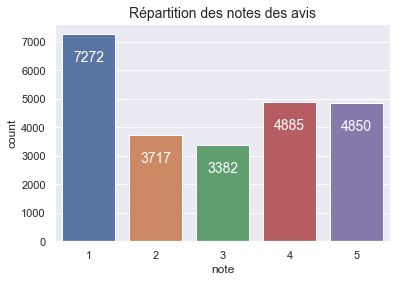

In [85]:
sns.set_theme(style="darkgrid")
countplot_avis = sns.countplot(x = "note", data = df)
countplot_avis.set_title('Répartition des notes des avis', fontsize=14)
# Ajout du count sur la visualisation
for p in countplot_avis.patches:
    countplot_avis.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=14)
countplot_avis

Let's create a function that take in input the note and the number of rows we want to generate.

In [86]:
def rows_generation(note: int, nb: int, replacement_ratio: float = 0.4):
    i = 0
    while i < nb:
        # Getting a random row with a given note
        review, note, produit, assureur = random_review_note(df, note)

        # Translating from french to english
        review = translation_dest_src(review,
                    source = 'fr',
                    destination = 'en')

        # Replacing words
        review = word_replacement(review, replacement_ratio)

        # Translating from english to french
        review = translation_dest_src(review,
                    source = 'en',
                    destination = 'fr')

        # Adding the new row in our dataframe
        # print (review)
        add_row(review[2:-2], note, produit[2:-2], assureur[2:-2])

        i += 1

In [87]:
rows_generation(3, 10, 0.2)
df

,date,note,auteur,avis,assureur,produit
0,06 septem...,5,brahim--k-131532,"Meilleurs assurances, prix, solutions, écoute,...",Direct Assurance,auto
1,03 mai 20...,4,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto
2,21 mars 2...,5,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,Direct Assurance,auto
3,10 juin 2...,4,boulain-f-116580,"je satisfait du service, une réponse très rapi...",L'olivier Assurance,auto
4,29 janvie...,1,ouaille31-51798,"Client depuis plus de 25 ans, très déçu de cet...",Matmut,auto
...,...,...,...,...,...,...
24111,data augmentation,3,data augmentation,Ne rembourse pas sans facture qui ne demande j...,Mercer,sante
24112,data augmentation,3,data augmentation,Je suis faute de la faute ... Suite d'attaquer...,Matmut,habitation
24113,data augmentation,3,data augmentation,"« » Bonjour, \ r \ r \ b \ r _ ntle de mon voi...",MACIF,auto
24114,data augmentation,3,data augmentation,"Je suis satisfait, mais je pense que cela aura...",Direct Assurance,auto


Let's try to have at least 4500 of each grades.

In [88]:
# For grades of 2
nb = 4500 - len(df[df['note'] == 2])
rows_generation(note = 2, nb = nb)

<AxesSubplot:title={'center':'Répartition des notes des avis'}, xlabel='note', ylabel='count'>

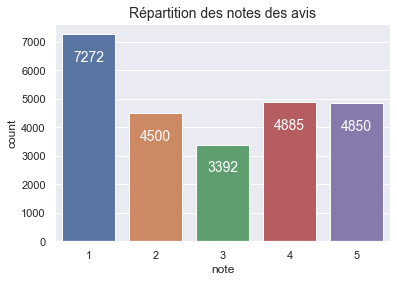

In [89]:
sns.set_theme(style="darkgrid")
countplot_avis = sns.countplot(x = "note", data = df)
countplot_avis.set_title('Répartition des notes des avis', fontsize=14)
# Ajout du count sur la visualisation
for p in countplot_avis.patches:
    countplot_avis.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=14)
countplot_avis

In [92]:
# For grades of 3
nb = 4500 - len(df[df['note'] == 3])
rows_generation(note = 3, nb = nb)

<AxesSubplot:title={'center':'Répartition des notes des avis'}, xlabel='note', ylabel='count'>

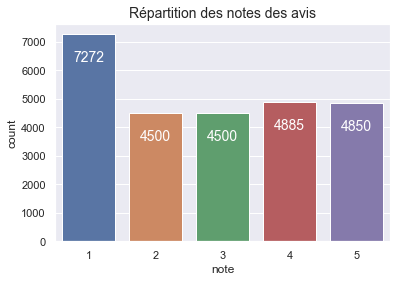

In [94]:
sns.set_theme(style="darkgrid")
countplot_avis = sns.countplot(x = "note", data = df)
countplot_avis.set_title('Répartition des notes des avis', fontsize=14)
# Ajout du count sur la visualisation
for p in countplot_avis.patches:
    countplot_avis.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=14)
countplot_avis

Exporting our augmented dataframe

In [95]:
df.to_pickle('df_augmented.pkl')